## Problem Statement

For a given future solution word on a future date, develop a model that allows you to predict the distribution of the reported results. In other words, to predict the associated percentages of (1, 2, 3, 4, 5, 6, X) for a future date. What uncertainties are associated with your model and predictions? Give a specific example of your prediction for the word EERIE on March 1, 2023. How confident are you in your model’s prediction?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
totWords = 2309
charRank = {'a': 906, 'b': 266, 'c': 446, 'd': 370, 'e': 1053, 'f': 206, 'g': 299, 'h': 377, 'i': 646, \
            'j': 27, 'k': 202, 'l': 645, 'm': 298, 'n': 548, 'o': 672, 'p': 345, 'q': 29, 'r': 835, \
            's': 617, 't': 667, 'u': 456, 'v': 148, 'w': 193, 'x': 37, 'y': 416, 'z': 35}
charRankByPos = [{'a': 140, 'b': 173, 'c': 198, 'd': 111, 'e': 72, 'f': 135, 'g': 115, 'h': 69, \
                  'i': 34, 'j': 20, 'k': 20, 'l': 87, 'm': 107, 'n': 37, 'o': 41, 'p': 141, 'q': 23, \
                  'r': 105, 's': 365, 't': 149, 'u': 33, 'v': 43, 'w': 82, 'y': 6, 'z': 3}, \
                 {'a': 304, 'b': 16, 'c': 40, 'd': 20, 'e': 241, 'f': 8, 'g': 11, 'h': 144, 'i': 201, 'j': 2, \
                  'k': 10, 'l': 200, 'm': 38, 'n': 87, 'o': 279, 'p': 61, 'q': 5, 'r': 267, 's': 16, 't': 77, \
                  'u': 185, 'v': 15, 'w': 44, 'x': 14, 'y': 22, 'z': 2}, {'a': 306, 'b': 56, 'c': 56, 'd': 75, \
                  'e': 177, 'f': 25, 'g': 67, 'h': 9, 'i': 266, 'j': 3, 'k': 12, 'l': 112, 'm': 61, 'n': 137, 'o': 243, \
                  'p': 57, 'q': 1, 'r': 163, 's': 80, 't': 111, 'u': 165, 'v': 49, 'w': 26, 'x': 12, 'y': 29, 'z': 11}, \
                 {'a': 162, 'b': 24, 'c': 150, 'd': 69, 'e': 318, 'f': 35, 'g': 76, 'h': 28, 'i': 158, 'j': 2, \
                  'k': 55, 'l': 162, 'm': 68, 'n': 182, 'o': 132, 'p': 50, 'r': 150, 's': 171, 't': 139, 'u': 82, \
                  'v': 45, 'w': 25, 'x': 3, 'y': 3, 'z': 20}, {'a': 63, 'b': 11, 'c': 31, 'd': 118, 'e': 422, 'f': 26, \
                  'g': 41, 'h': 137, 'i': 11, 'k': 113, 'l': 155, 'm': 42, 'n': 130, 'o': 58, 'p': 56, 'r': 212, 's': 36, \
                  't': 253, 'u': 1, 'w': 17, 'x': 8, 'y': 364, 'z': 4}]

def charCount(s):
    dic = {}
    for ch in s:
        try:
            dic[ch] += 1
        except KeyError:
            dic[ch] = 1
    return dic

def calc_roc(s): 
    dic = charCount(s)
    l = [val for val in dic.values()]
    return stats.entropy(l)

def calc_pov(s):
    I2 = 0
    for c in s:
        if c in ["a", "e", "i", "o", "u"]: I2 += 1
    return I2 / 5

def calc_rank():
    with open("./dataset/wordle_wordbank.txt") as f:
        lines = f.readlines()
    print(len(lines))
    lines = [s.strip() for s in lines]
    dic = {}
    dic2 = [{} for _ in range(5)]
    for s in lines:
        for c in set(s.lower()):
            try: dic[c] += 1
            except KeyError: dic[c] = 1
        for i, c in enumerate(s):
            try: dic2[i][c] += 1
            except KeyError: dic2[i][c] = 1
    return dict(sorted(dic.items())), [dict(sorted(dic2[i].items())) for i in range(5)]

def calc_EYH(s):
    I3 = 0
    for c in set(s):
        I3 += charRank[c] / totWords
    return I3

# I3G is expectation of green hits
def calc_EGH(s):
    I3 = 0
    for i, c in enumerate(s):
        I3 += charRankByPos[i][c] / totWords
    return I3

First, read the dates and the corresponding data.

In [4]:
df = pd.read_excel("./dataset/wordle_data.xlsx", index_col=0, usecols="A,C,F:L")
df = df.sort_index()

Break down the words into characters, and transform a-z into 0-25.

In [5]:
df_chars = pd.DataFrame(index=df.index, data=[[ord(c) - 97 for c in ch] for ch in df["word"].apply(func=list).values], columns=["ch1", "ch2", "ch3", "ch4", "ch5"])
df[df_chars.columns] = df_chars

ROC, EYH, and EGH are validated as correlating (at least moderately) to the distribution of the number of trials.

In [6]:
df["ROC"] = [calc_roc(word) for word in df["word"]]
df["EYH"] = [calc_EYH(word) for word in df["word"]]
df["EGH"] = [calc_EGH(word) for word in df["word"]]

Now we need to split the data into a training set and a testing set, and determine the input attributes and output attributes.

In [7]:
output_attrs = ["trial_1", "trial_2", "trial_3", "trial_4", "trial_5", "trial_6", "trial_x"]
input_attrs = ["ch1", "ch2", "ch3", "ch4", "ch5", "ROC", "EYH", "EGH"]
X_train, X_test, y_train, y_test = train_test_split(df[input_attrs], df[output_attrs], test_size=0.25, random_state=1)
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (269, 8)
Testing set: (90, 8)


### Random Forest Regression

Validate the model using mean absolute error.

In [8]:
rand_forest = RandomForestRegressor(n_estimators=500, max_depth=4, random_state=1)
rand_forest.fit(X_train, y_train)
rf_train = np.round(rand_forest.predict(X_train))
rf_test = np.round(rand_forest.predict(X_test))
maes_train = np.mean(np.absolute(rf_train - y_train.to_numpy()), axis=0)
maes_test = np.mean(np.absolute(rf_test - y_test.to_numpy()), axis=0)
for i in range(len(maes_train)):
    print("Mean absolute error ({}): train = {:.4f}, test = {:.4f}".format(output_attrs[i], maes_train[i], maes_test[i]))

Mean absolute error (trial_1): train = 0.4387, test = 0.4000
Mean absolute error (trial_2): train = 1.8736, test = 3.0111
Mean absolute error (trial_3): train = 4.2639, test = 5.5778
Mean absolute error (trial_4): train = 3.4424, test = 3.6222
Mean absolute error (trial_5): train = 3.2639, test = 4.5000
Mean absolute error (trial_6): train = 3.6506, test = 4.0556
Mean absolute error (trial_x): train = 1.7063, test = 2.3333


Initialize the input attributes of the target word EERIE, retrain the same model on the using the whole dataset, and make the corresponding prediction.

In [9]:
eerie_attrs = {"ch1": ord("e") - 97, "ch2": ord("e") - 97, "ch3": ord("r") - 97, "ch4": ord("i") - 97, "ch5": ord("e") - 97, \
               "ROC": calc_roc("eerie"), "EYH": calc_EYH("eerie"), "EGH": calc_EGH("eerie")}
rand_forest_final = RandomForestRegressor(n_estimators=500, max_depth=4, random_state=1)
rand_forest_final.fit(df[input_attrs], df[output_attrs])
X_pred = pd.DataFrame(index=[pd.to_datetime("2023/03/01", format="%Y-%m-%d")], data=eerie_attrs)
y_pred = np.round(rand_forest_final.predict(X_pred)).reshape(-1)
for i in range(len(output_attrs)):
    print("{}: {:.0f}%".format(output_attrs[i], y_pred[i]))
print("Sum: {:.0f}%".format(np.sum(y_pred)))

trial_1: 0%
trial_2: 4%
trial_3: 18%
trial_4: 32%
trial_5: 27%
trial_6: 15%
trial_x: 4%
Sum: 100%


Plot the prediction result.

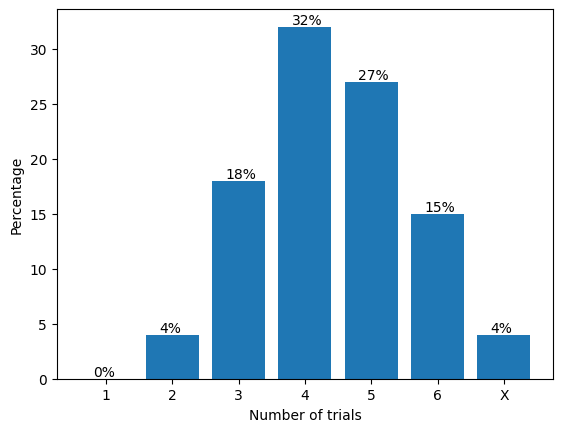

In [10]:
plt.bar(["1", "2", "3", "4", "5", "6", "X"], y_pred)
for i, v in enumerate(y_pred):
    plt.text(x=i-0.2, y=v+0.2, s="{:.0f}%".format(v) , fontdict=dict(fontsize=10))
plt.xlabel("Number of trials")
plt.ylabel("Percentage")
plt.show()